In [1]:
import datetime

import numpy as np
import radtran
import torch
import xarray as xr
from matplotlib import pyplot as plt
from pydantic import AnyUrl

from src.azure_wrap.ml_client_utils import (
    create_ml_client_config,
    get_default_blob_storage,
)
from src.data.common.data_item import MonoTemporalPlumesDataItem
from src.data.common.utils import tensor_to_dataarray
from src.data.emit_data import EMITL2AMaskLabel
from src.data.generation.base import DataGenerationConfig
from src.data.generation.emit_generation import EMITDataGeneration
from src.inference.inference_functions import load_and_crop_emit_image_for_point, predict
from src.plotting.plotting_functions import (
    get_rgb_from_xarray,
    get_swir_ratio_from_xarray,
    grid16,
    plot_frac,
)
from src.training.loss_functions import TwoPartLoss
from src.utils.parameters import SatelliteID
from src.utils.radtran_utils import (
    compute_normalized_brightness,
    precompute_log_norm_brightness,
)
from src.utils.utils import (
    earthaccess_login,
    initialize_clients,
    load_model_and_concatenator,
    setup_device_and_distributed_model,
    setup_distributed_processing,
)

/anaconda/envs/methane-cv-2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize clients
ml_client, _, _, s3_client = initialize_clients(False)
earthaccess_login(ml_client)
cache_container_name = get_default_blob_storage(ml_client).container_name

Found the config file in: /config.json


##### Get Gorrono plume as a test

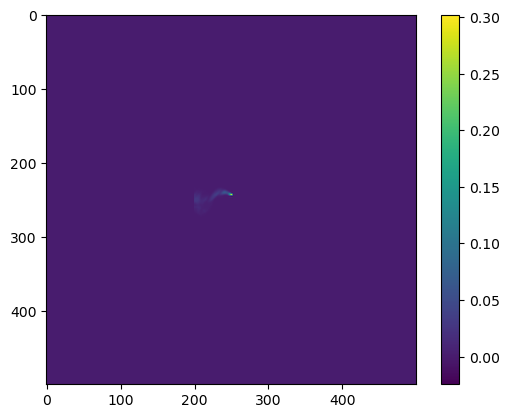

In [3]:
gorrono_plume = np.load("data/gorrono_plumes/0/methane_enhancement (1).npy") * 10000
gorrono_plume_mask = np.load("data/gorrono_plumes/0/mask.npy")
plt.imshow(gorrono_plume)
plt.colorbar()
plt.show()

#### Load model and model parameters

In [4]:
# load model
model_identifier = "models:/emit/60"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, band_extractor, training_params = load_model_and_concatenator(model_identifier, "cpu", SatelliteID.EMIT)
lossFn = TwoPartLoss(
    binary_threshold=training_params["binary_threshold"], MSE_multiplier=training_params["MSE_multiplier"]
)

2025-04-17 15:39:50,228 - INFO - Parsing tracking uri /mlflow/v1.0/subscriptions/6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab/resourceGroups/orbio-ml-rg/providers/Microsoft.MachineLearningServices/workspaces/orbio-ml-ml-workspace
2025-04-17 15:39:50,229 - INFO - Tracking uri /mlflow/v1.0/subscriptions/6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab/resourceGroups/orbio-ml-rg/providers/Microsoft.MachineLearningServices/workspaces/orbio-ml-ml-workspace has sub id 6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab, resource group orbio-ml-rg, and workspace orbio-ml-ml-workspace
2025-04-17 15:39:50,230 - INFO - Fetched cloud name from environment variable AZUREML_CURRENT_CLOUD
2025-04-17 15:39:50,433 - INFO - Parsing artifact uri azureml://westeurope.api.azureml.ms/mlflow/v2.0/subscriptions/6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab/resourceGroups/orbio-ml-rg/providers/Microsoft.MachineLearningServices/workspaces/orbio-ml-ml-workspace/experiments/3f0e1005-b8a5-4083-9081-9c226894c10d/runs/crimson_receipt_nyv50rh4wx/artifacts/emi

#### Create synthetic EMIT data


In [5]:
satellite_params = {
    "emit_id": "EMIT_L1B_RAD_001_20231010T082557_2328306_008",
    "emit_mask_labels": [
        EMITL2AMaskLabel.CLOUD,
        EMITL2AMaskLabel.CIRRUS_CLOUD,
        EMITL2AMaskLabel.DILATED_CLOUD,
        EMITL2AMaskLabel.WATER,
        EMITL2AMaskLabel.SPACECRAFT,
    ],
}

base_config = DataGenerationConfig(
    plume_catalog="azureml://subscriptions/6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab/resourcegroups/orbio-ml-rg/workspaces/orbio-ml-ml-workspace/datastores/workspaceblobstore/paths/aviris_plumes/validation_set_20perc_plume_catalog.json",
    plume_type="carbonmapper",
    out_dir="",
    crop_size=128,
    quality_thresholds={"main_crop": [0.2, 0.5]},
    random_seed=42,
    transformation_params={"modulate": 1.0, "resize": 1.0},
    azure_cluster=False,
    git_revision_hash="",
    test=False,
    ml_client=ml_client,
    s3_client=s3_client,
    storage_options=None,
    psf_sigma=12.42,
    target_spatial_resolution=60,  # TODO: should this be taken from the satellite hydra configs?
    concentration_rescale_value=1,
    plume_proba_dict={"0": 0.2, "1": 0.8},
    hapi_data_path="azureml://subscriptions/6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab/resourcegroups/orbio-ml-rg/workspaces/orbio-ml-ml-workspace/datastores/workspaceblobstore/paths/data/radtran/hapi/v1.1.1.0",
)

emit_generator = EMITDataGeneration(**satellite_params, **base_config.model_dump())

In [9]:
data = emit_generator.download_data()
tile_level_data = emit_generator.prepare_tile_level_data(data)
tile_crops = emit_generator.generate_crops(data)

CH4_absorption_da = emit_generator._prepare_absorption_data(emit_generator.hapi_data_path)

# Precompute brightness lookup
log_normalized_brightness = precompute_log_norm_brightness(
    sensor_band_parameters=tile_level_data["sensor_band_parameters"],
    CH4_absorption=CH4_absorption_da,
    gamma_concentration=2 * np.array([0.00001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]),
)

Precomputing log-normalized brightness:   0%|          | 0/7 [00:00<?, ?it/s]/anaconda/envs/methane-cv-2/lib/python3.10/site-packages/scipy/special/_logsumexp.py:219: RuntimeWarning: overflow encountered in divide
  s = xp.where(s == 0, s, s/m)
Precomputing log-normalized brightness: 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


Computing normalized brightness: 100%|██████████| 285/285 [00:00<00:00, 581.83it/s]
2025-04-17 15:57:02,799 - INFO - Biggest reduction factor: 0.9976
Computing normalized brightness: 100%|██████████| 285/285 [00:00<00:00, 586.65it/s]
2025-04-17 15:57:03,385 - INFO - Biggest reduction factor: 0.9927
Computing normalized brightness: 100%|██████████| 285/285 [00:00<00:00, 566.20it/s]
2025-04-17 15:57:03,975 - INFO - Biggest reduction factor: 0.9880
Computing normalized brightness: 100%|██████████| 285/285 [00:00<00:00, 575.79it/s]
2025-04-17 15:57:04,554 - INFO - Biggest reduction factor: 0.9763
Computing normalized brightness: 100%|██████████| 285/285 [00:00<00:00, 582.09it/s]
2025-04-17 15:57:05,126 - INFO - Biggest reduction factor: 0.8973
Computing normalized brightness: 100%|██████████| 285/285 [00:00<00:00, 583.92it/s]
2025-04-17 15:57:05,696 - INFO - Biggest reduction factor: 0.8134
Computing normalized brightness: 100%|██████████| 285/285 [00:00<00:00, 561.48it/s]
2025-04-17 15:57

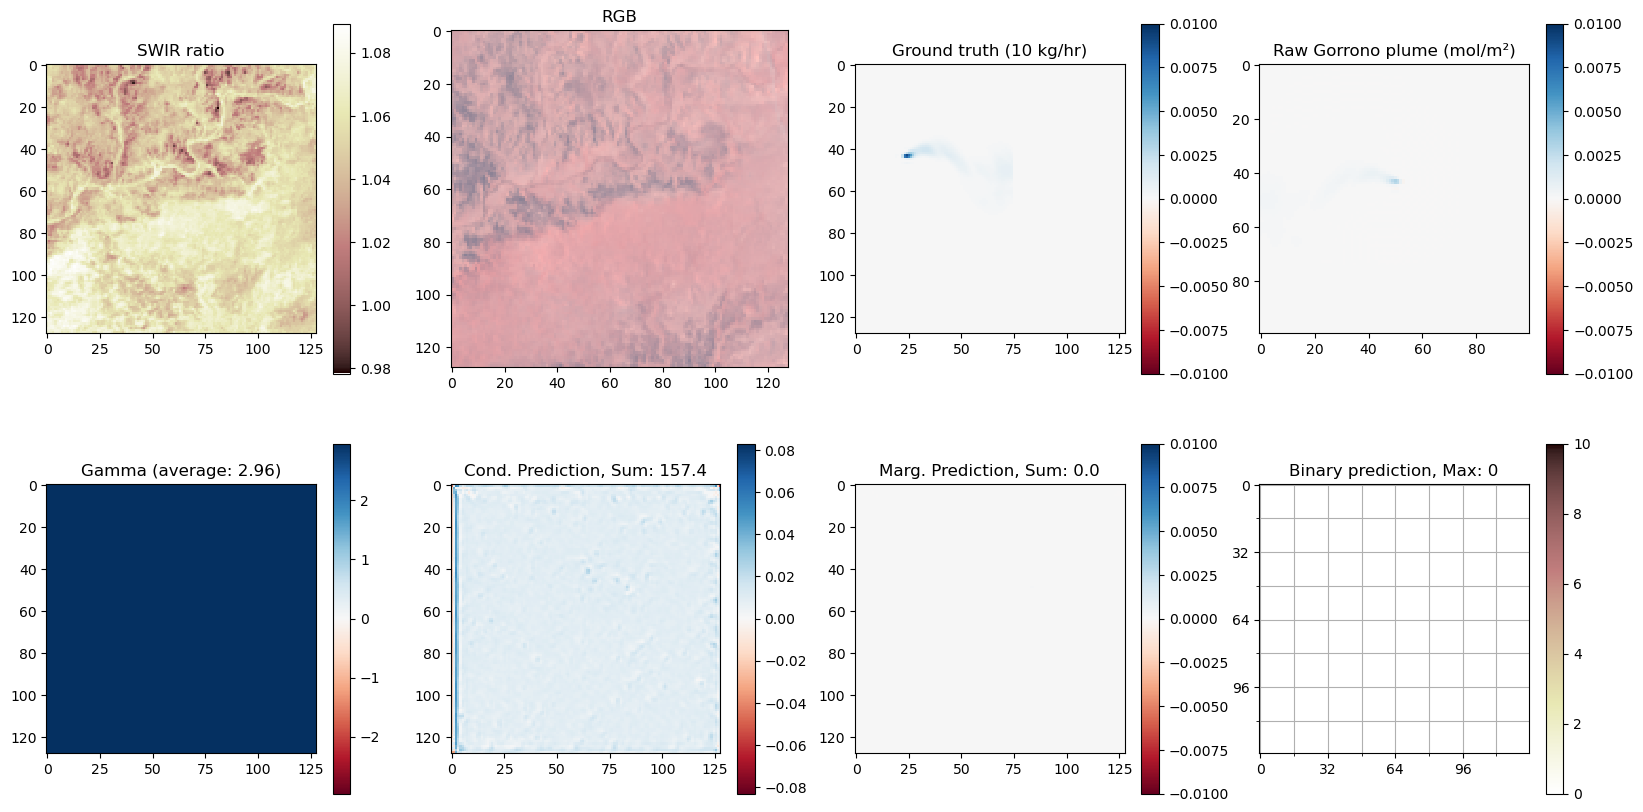

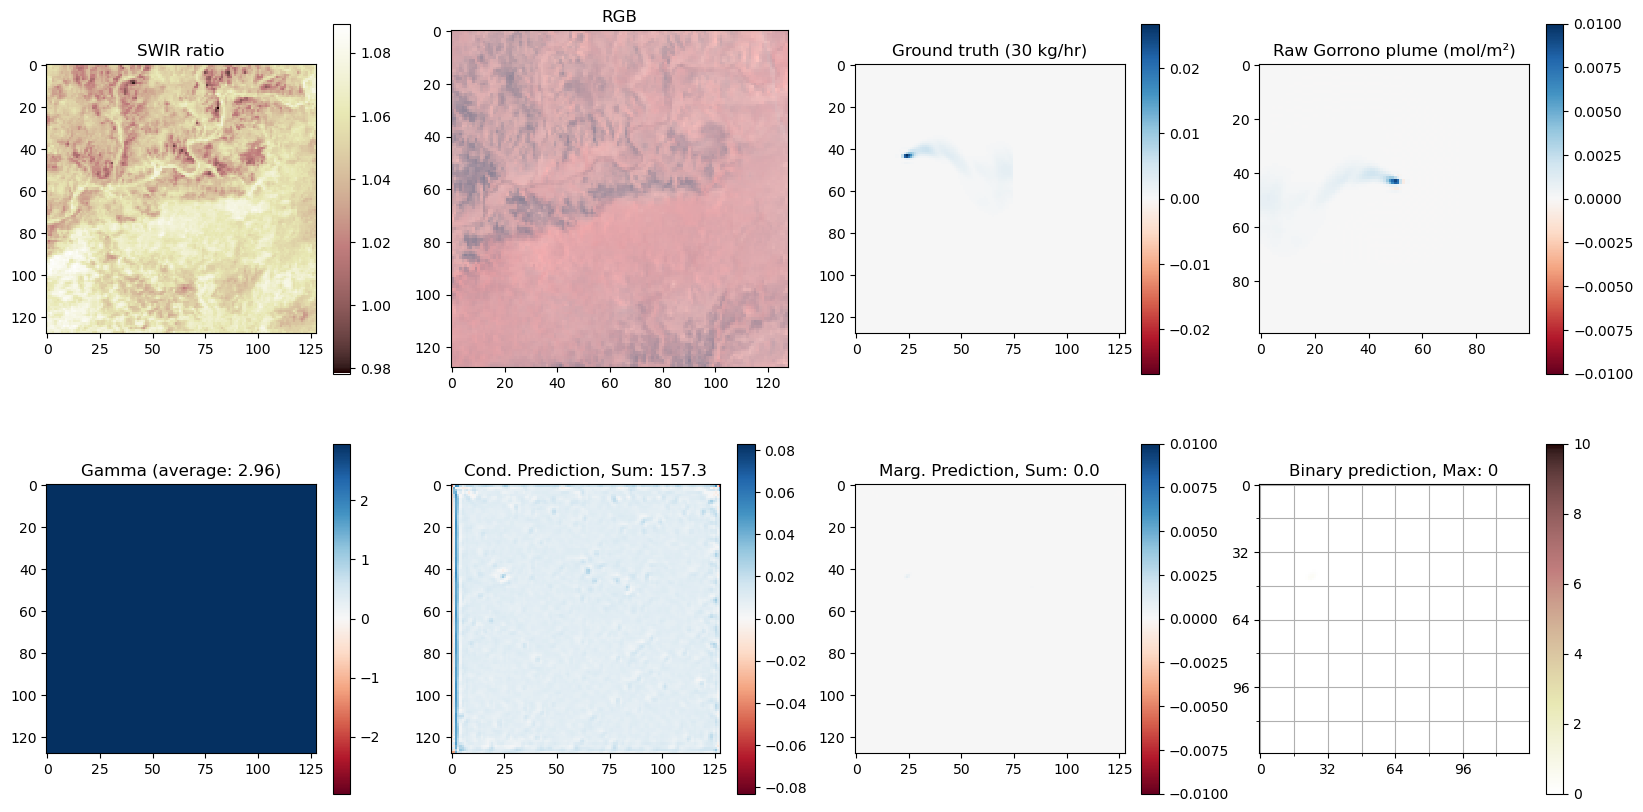

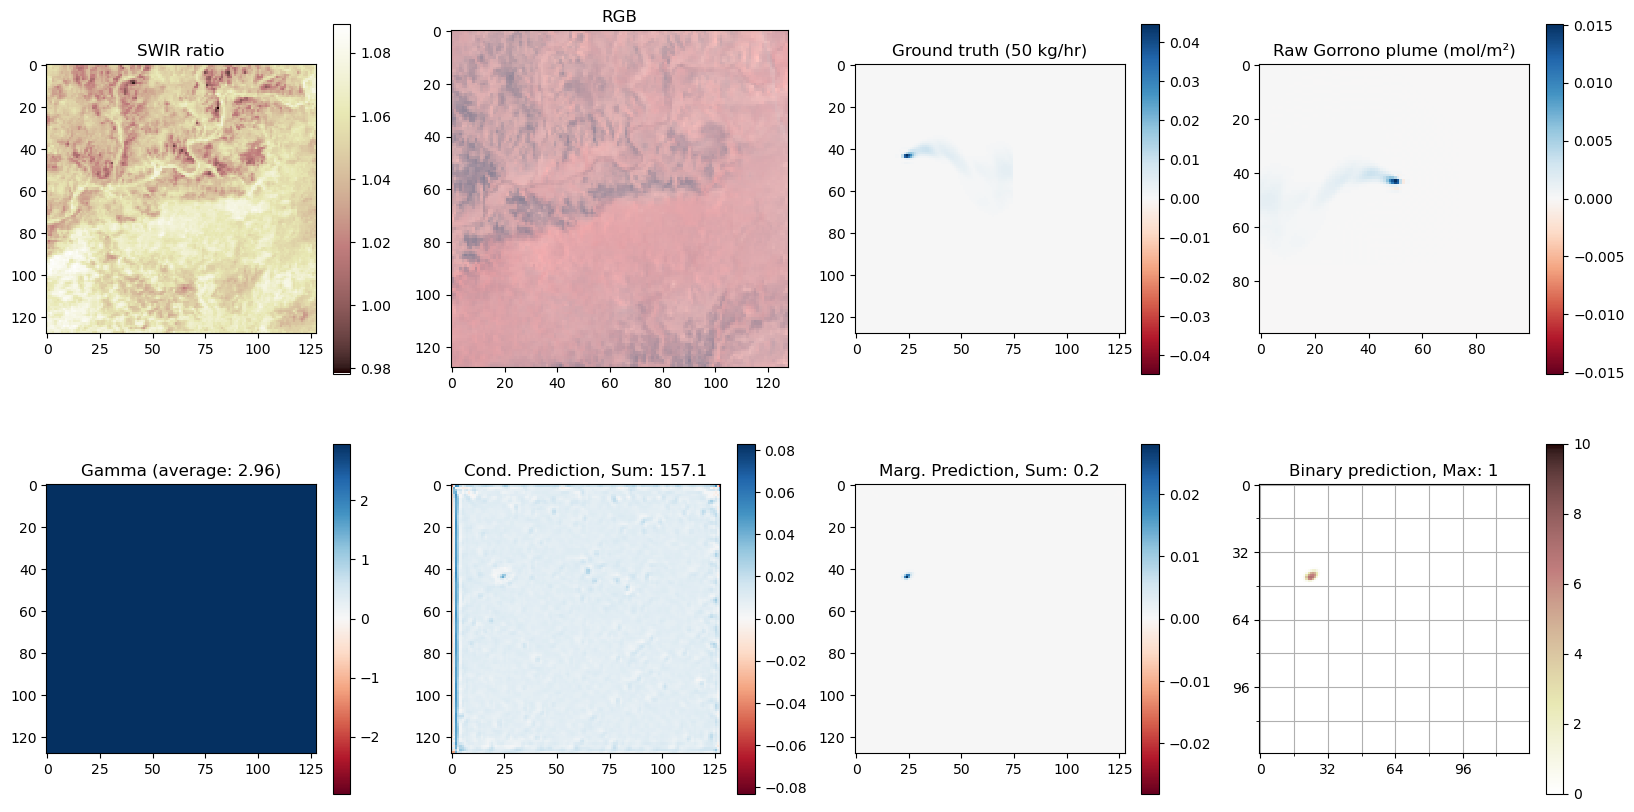

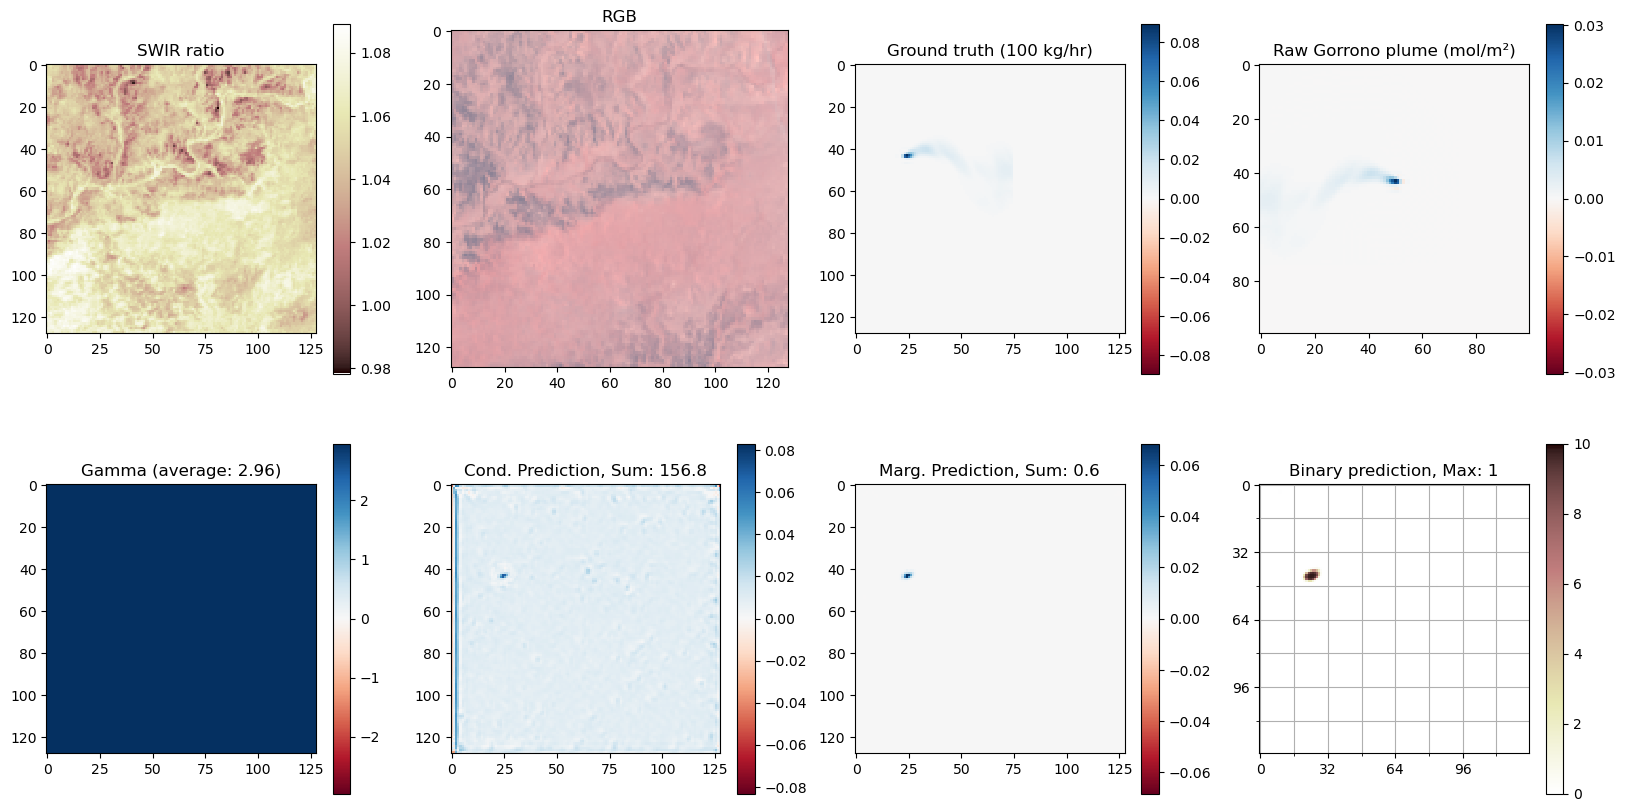

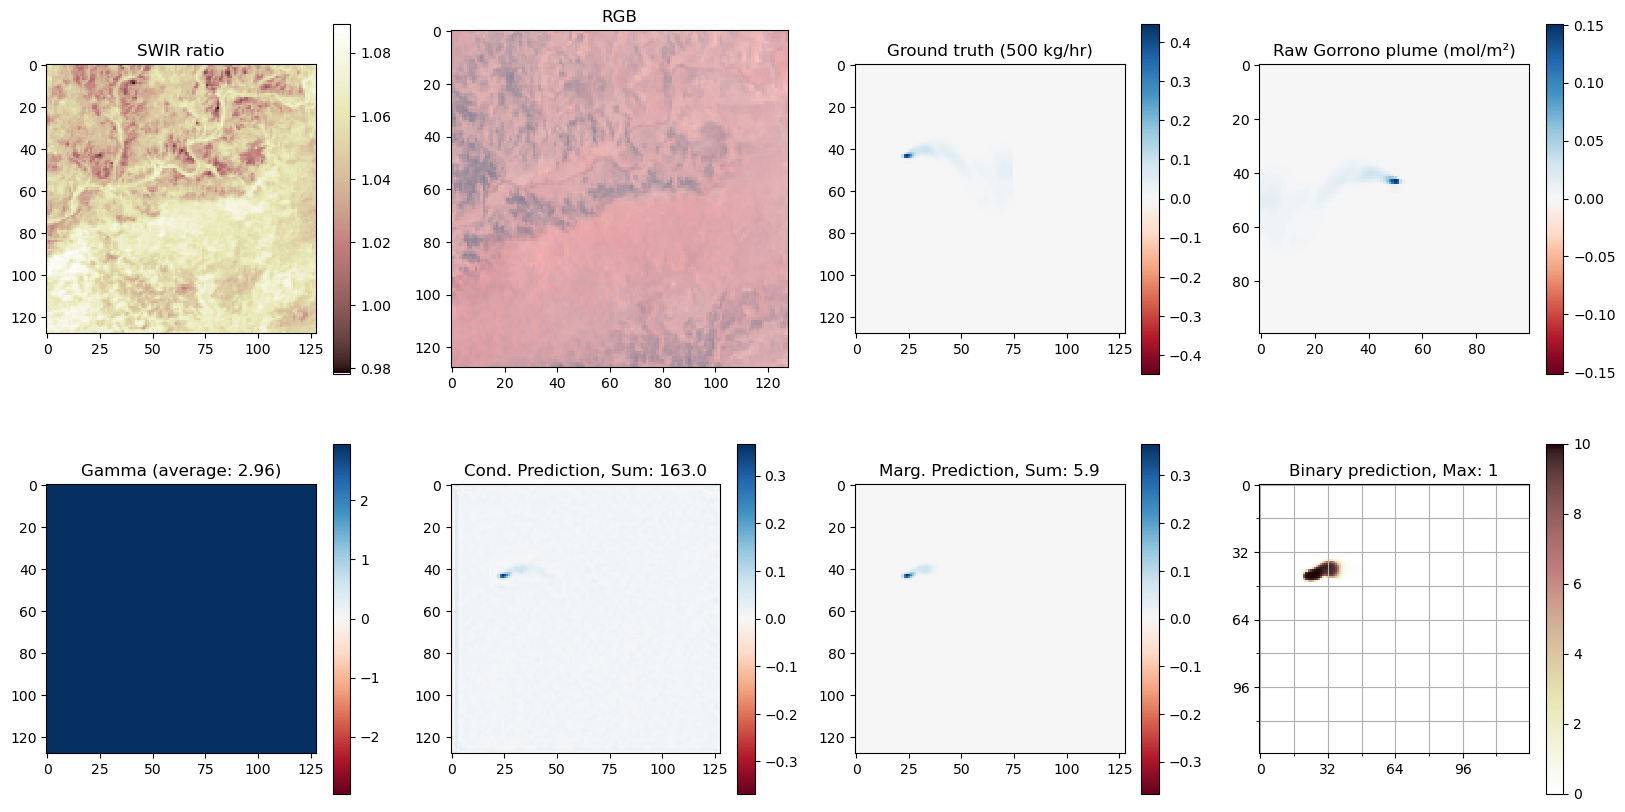

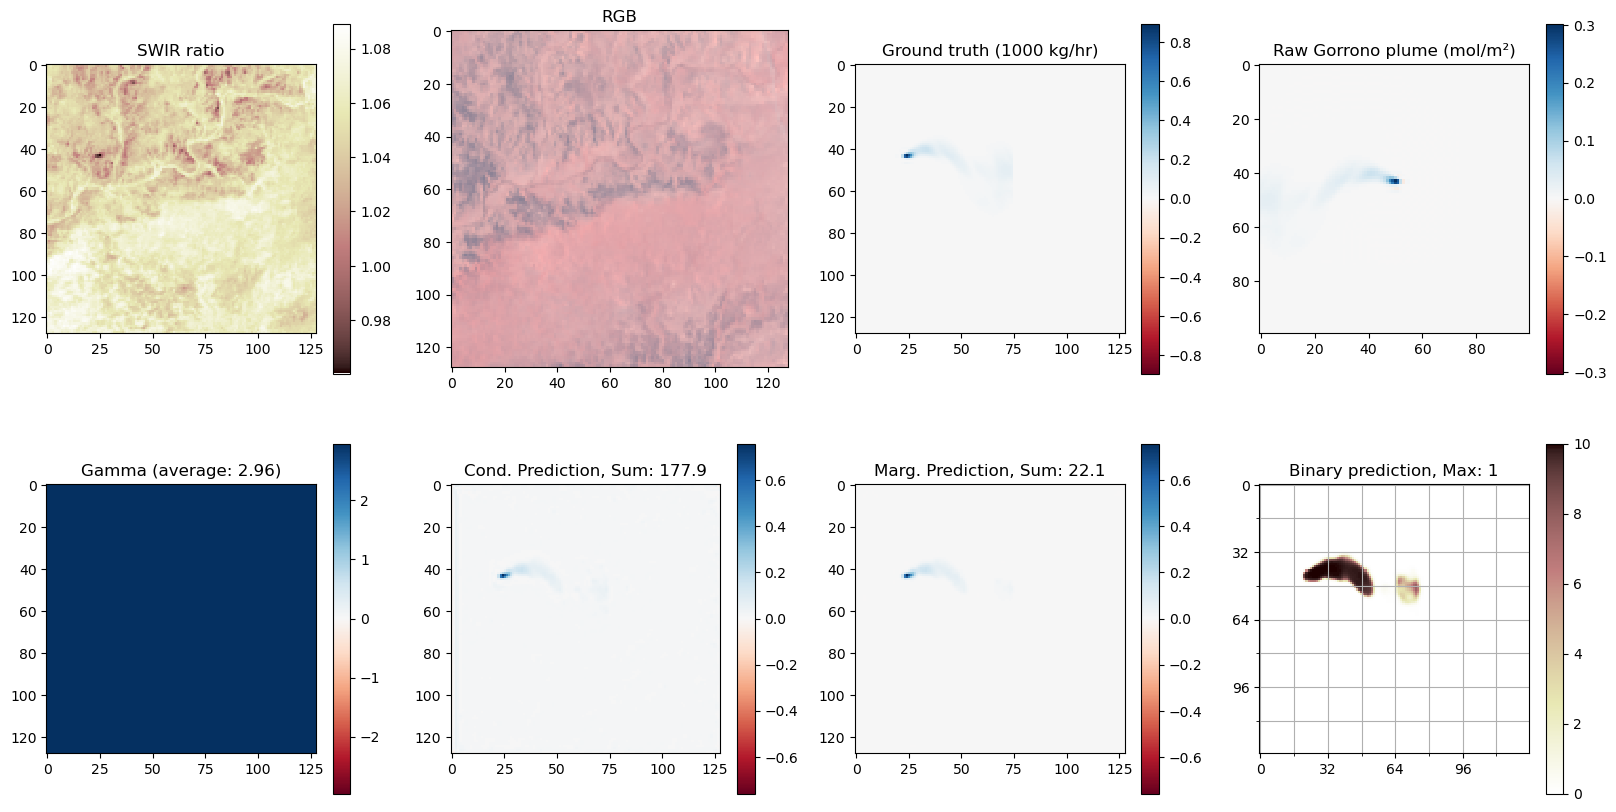

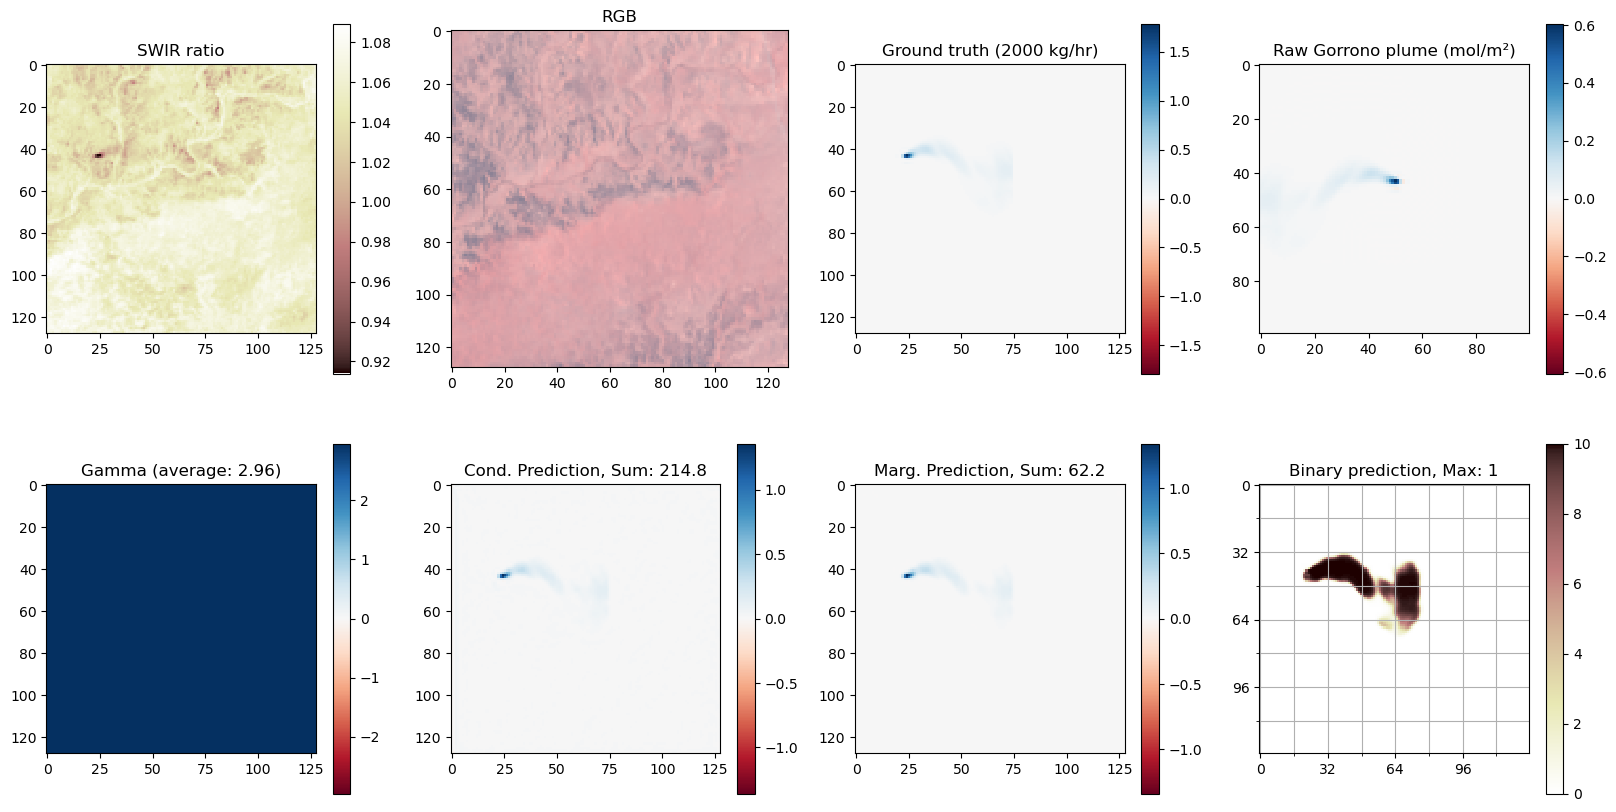

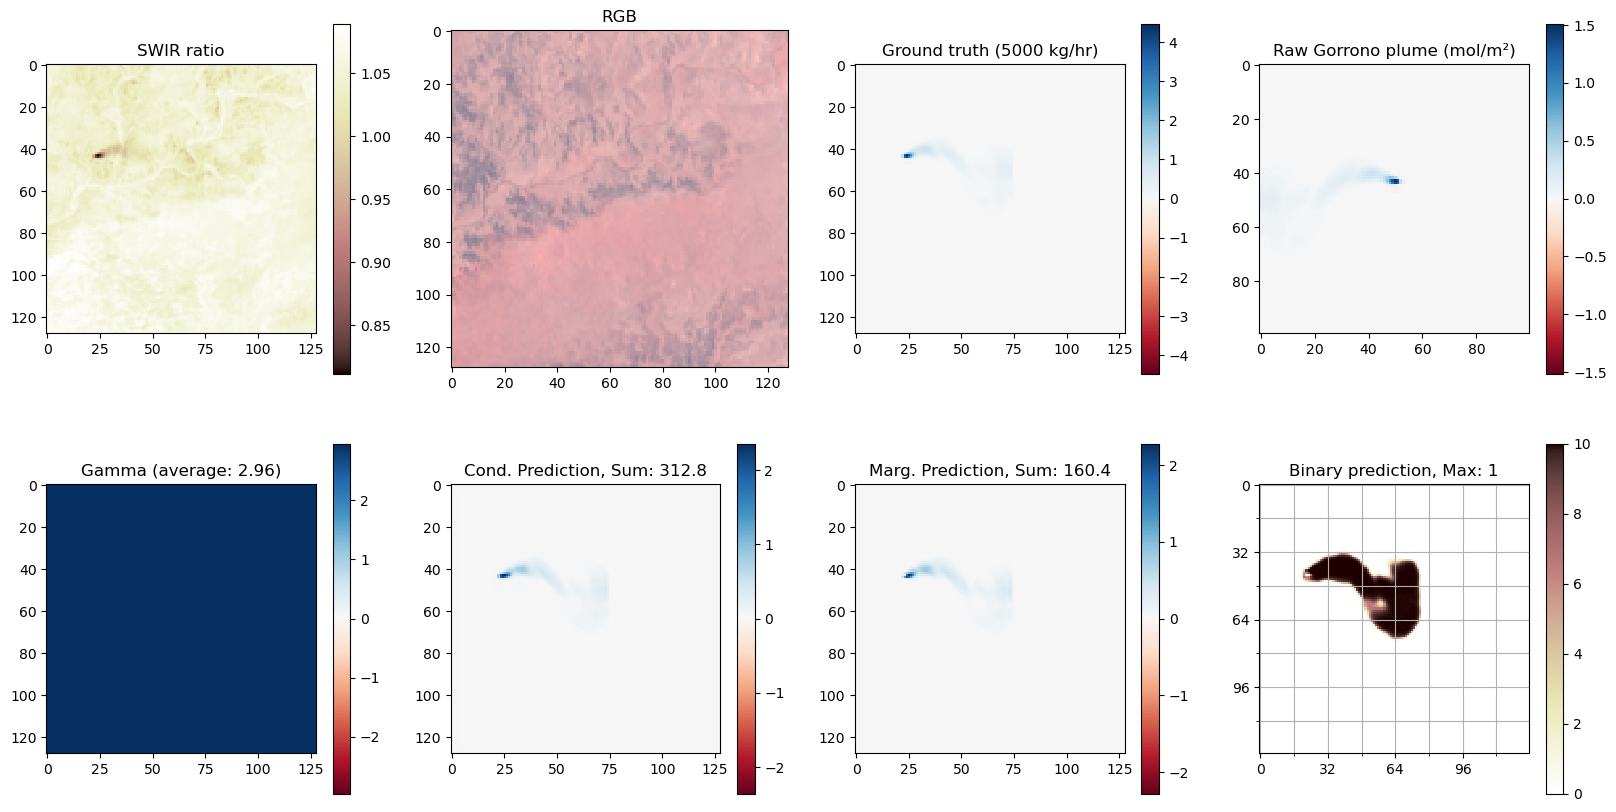

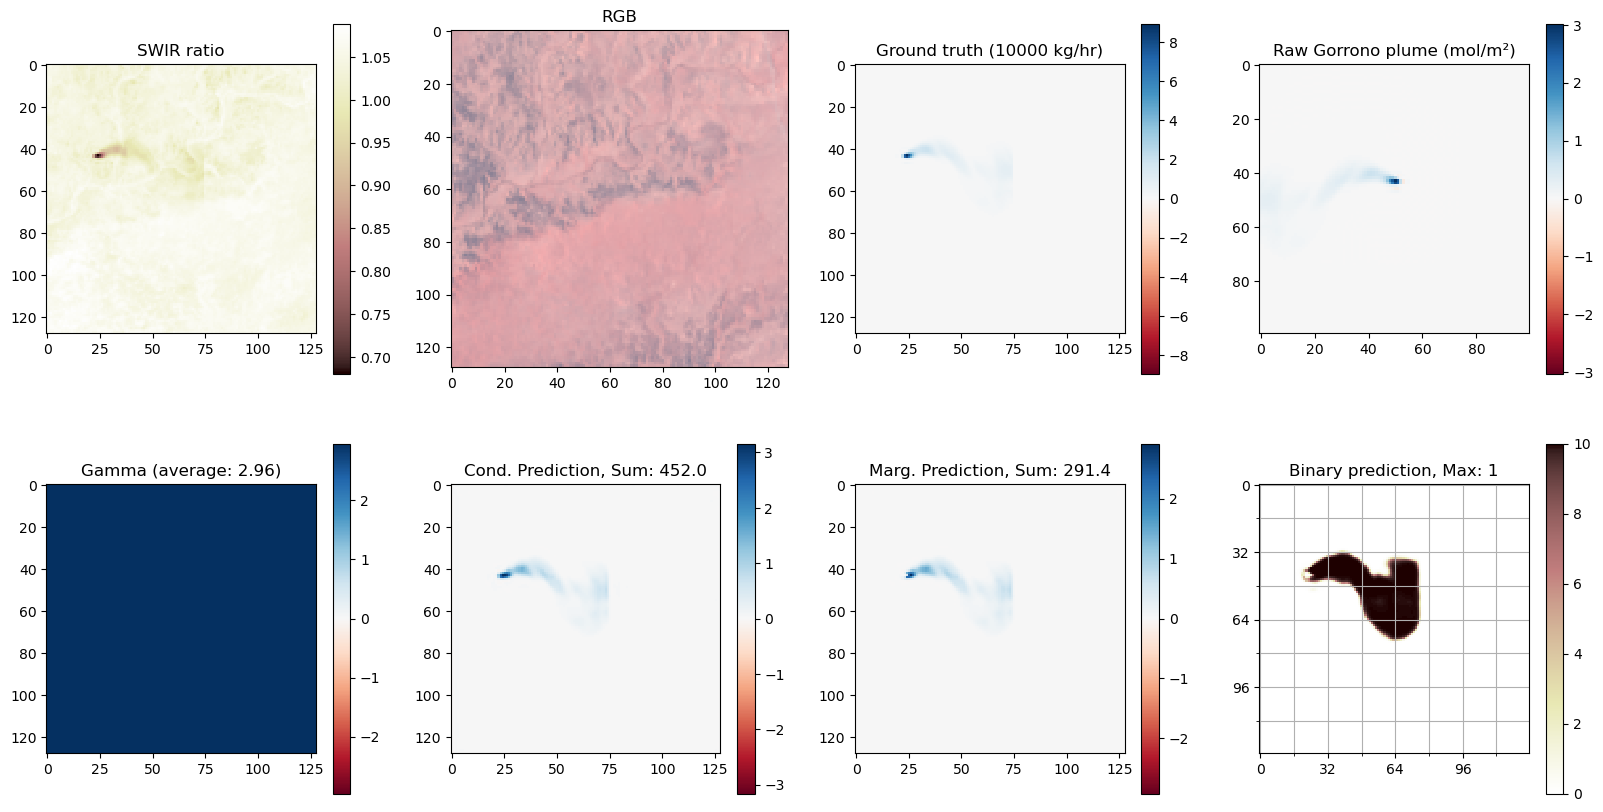

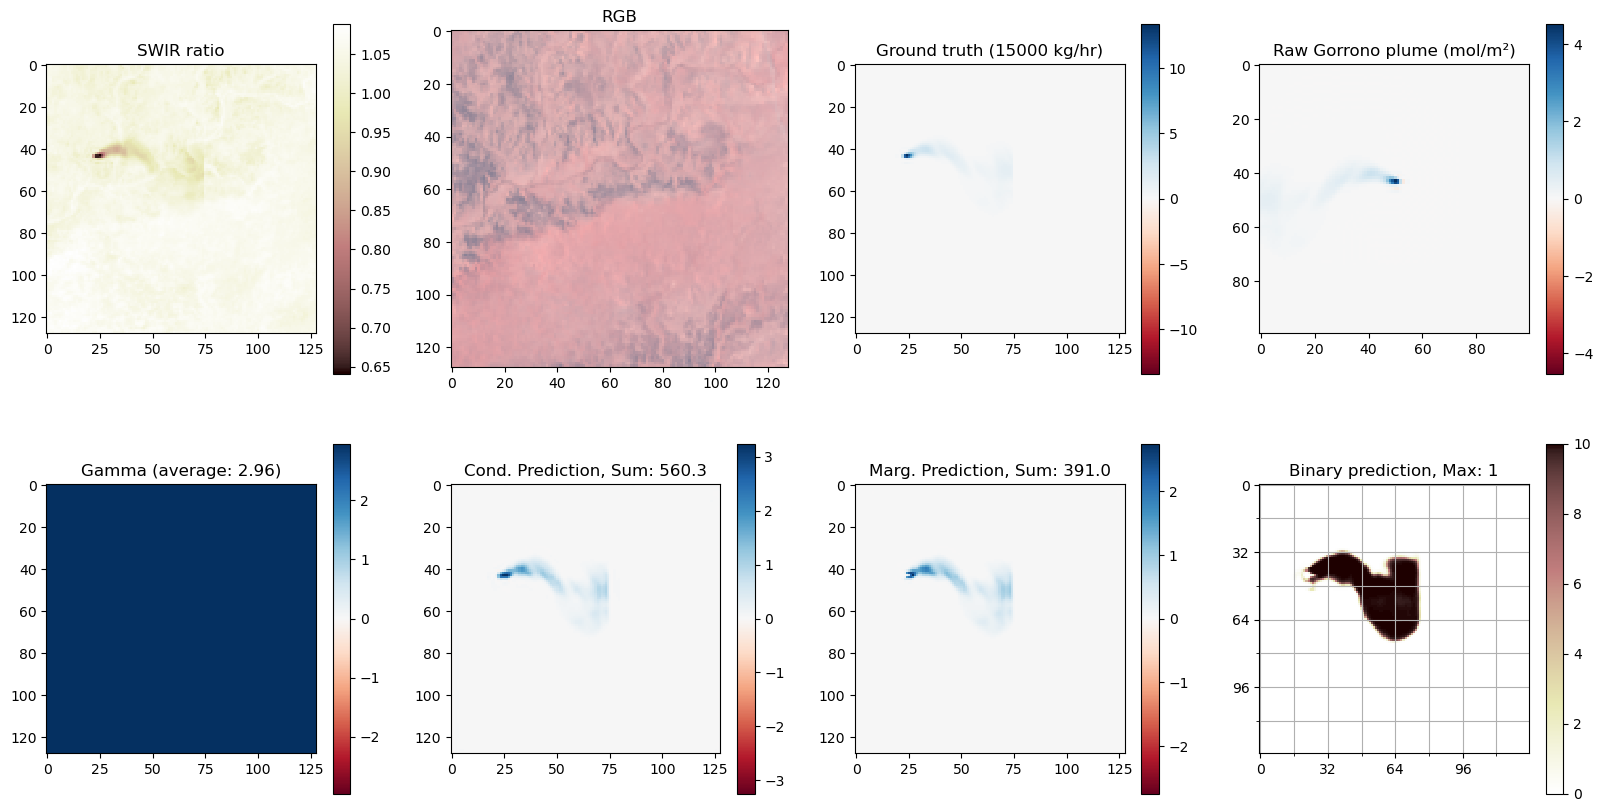

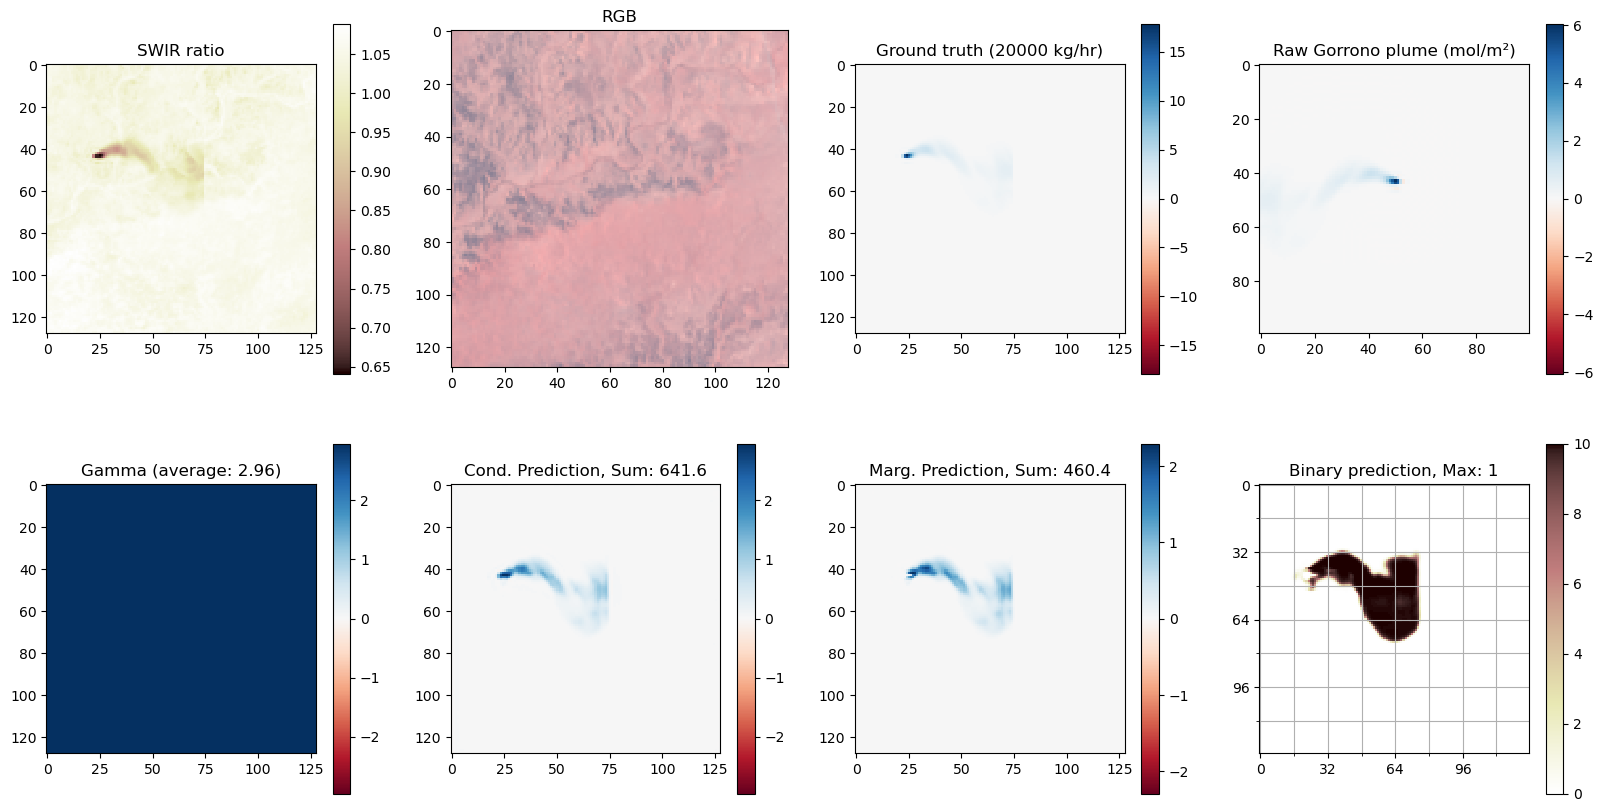

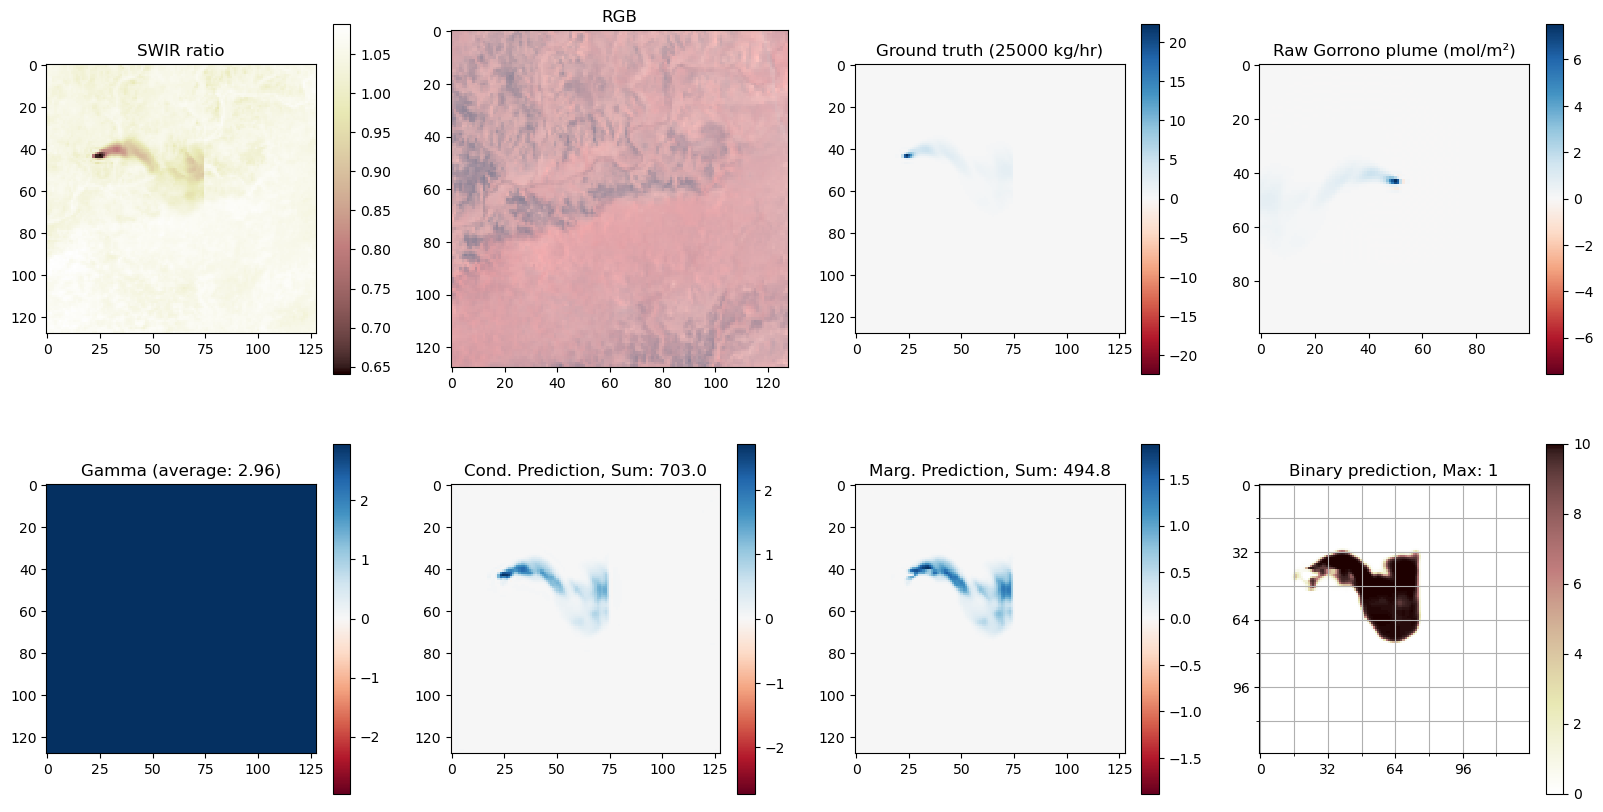

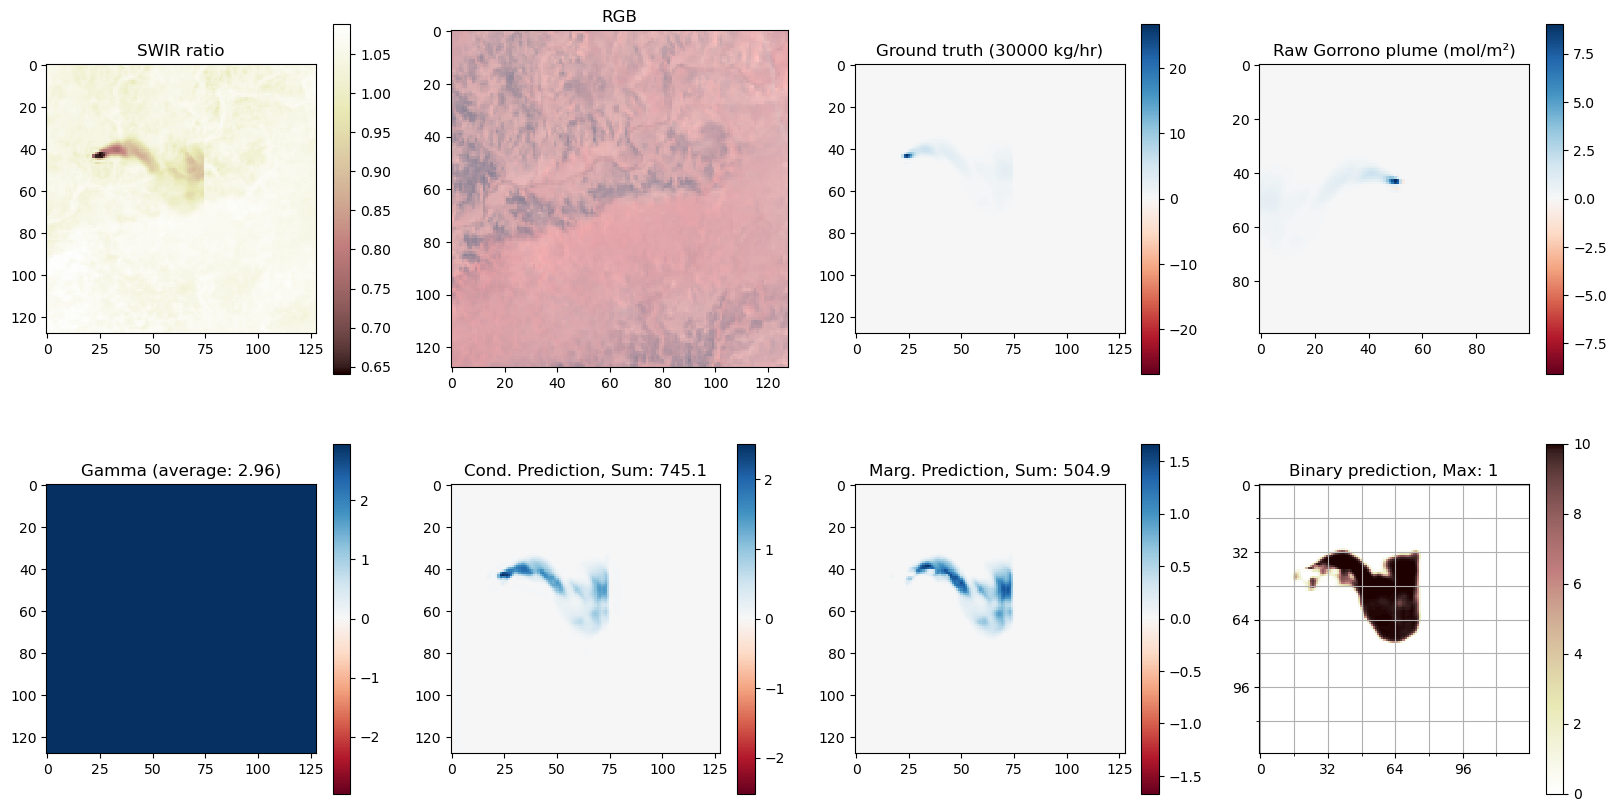

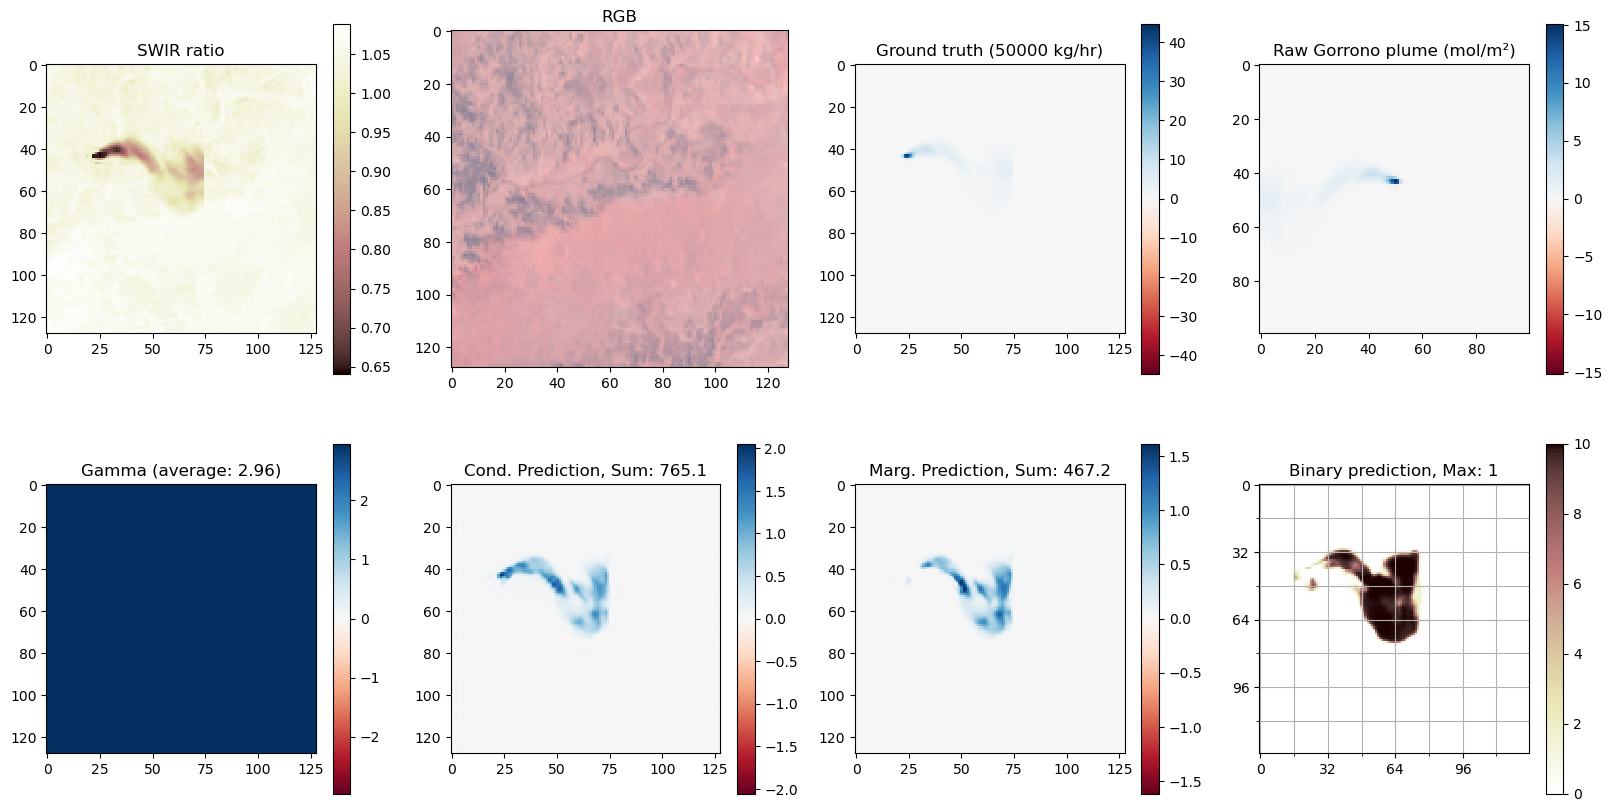

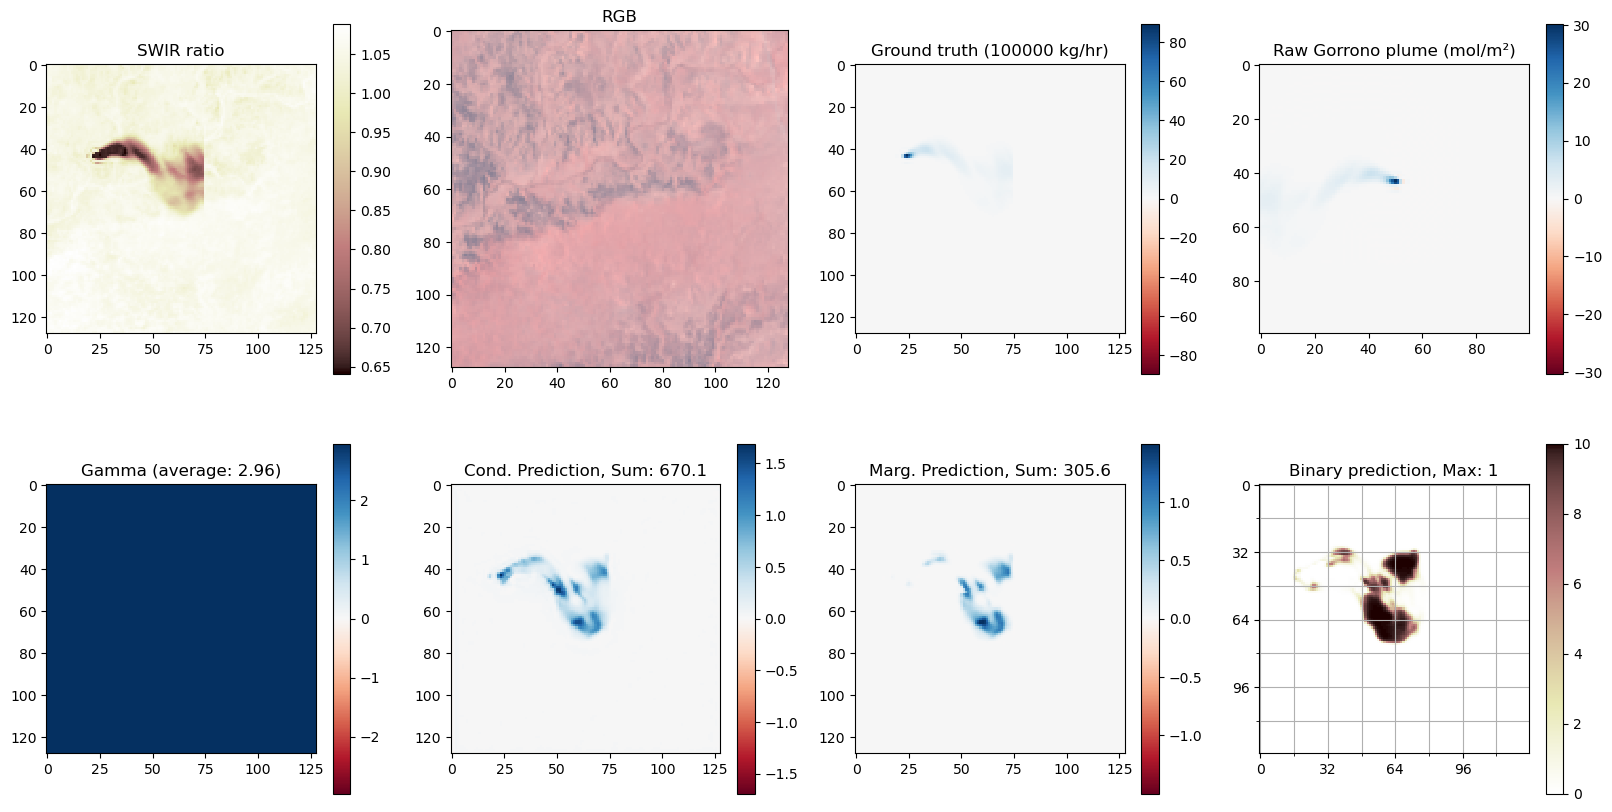

In [10]:
def generate_synthetic_data(emit_generator, plume, crops, log_normalized_brightness, scale_factors):
    items = []
    for i, crop in enumerate(crops):
        rad_crop = crop["rad_crop"]
        obs_crop = crop["obs_crop"]
        mask_crop = crop["mask_crop"]
        crop_x = crop["crop_x"]
        crop_y = crop["crop_y"]
        cloud_ratio = crop["cloud_ratio"]

        sensing_time = obs_crop.attrs["time_coverage_start"]

        for scale_factor in scale_factors:
            sim = emit_generator._add_plumes(
                rad_crop,
                obs_crop,
                mask_crop,
                [plume * scale_factor],
                emit_generator.rng,
                emit_generator.transformation_params,
                log_normalized_brightness,
            )

            data_item = MonoTemporalPlumesDataItem.create_data_item(
                modified_crop=sim.radiance.fillna(0),
                target=sim.enhancement * sim.gamma,  # the target variable is the plume concentration times gamma
                mask=mask_crop,
                granule_id=emit_generator.emit_id,
                plume_files=[],
                bands=list(rad_crop.bands.values),
                size=emit_generator.crop_size,
                crop_x=crop_x,
                crop_y=crop_y,
                main_cloud_ratio=cloud_ratio,
                transformation_params=emit_generator.transformation_params,
                region_overlap=None,
            )

            item = {"data_item": data_item, "scale_factor": scale_factor, "sim": sim, "plume": plume * scale_factor}

            items.append(item)

        return (
            items,
            sensing_time,
        )


def modulate_and_predict(emit_generator, raw_plume, crops, log_normalized_brightness, scale_factors):
    items, sensing_time = generate_synthetic_data(
        emit_generator, raw_plume, crops, log_normalized_brightness, scale_factors
    )

    for item in items:
        scale_factor = item["scale_factor"]
        data_item = item["data_item"]
        sim = item["sim"]
        sim_plume = item["plume"]
        target_retrieval = data_item.target

        pred = predict(model, device, band_extractor, data_item, lossFn)
        crop_main = tensor_to_dataarray(pred["x_dict"]["crop_main"][0], data_item.bands)

        marginal_pred = pred["marginal_pred"].squeeze()
        binary_probability = pred["binary_probability"].squeeze()
        conditional_pred = pred["conditional_pred"].squeeze()

        # TODO: add quantification

        fig = plt.figure(figsize=(20, 10))

        plt.subplot(2, 4, 1)
        plt.title("SWIR ratio")
        swir_ratio = get_swir_ratio_from_xarray(crop_main, SatelliteID.EMIT)
        plt.imshow(swir_ratio, interpolation="nearest", cmap="pink")
        plt.colorbar()

        plt.subplot(2, 4, 2)
        plt.title("RGB")
        rgb_image = get_rgb_from_xarray(crop_main, SatelliteID.EMIT)
        plt.imshow(rgb_image / rgb_image.max(), interpolation="nearest")

        plt.subplot(2, 4, 3)
        plt.title(f"Ground truth ({1000*scale_factor:.0f} kg/hr)")
        plot_frac(target_retrieval)
        plt.colorbar()

        plt.subplot(2, 4, 4)
        plt.title("Raw Gorrono plume (mol/m²)")
        plot_frac(sim_plume[200:300, 200:300])
        plt.colorbar()

        plt.subplot(2, 4, 5)
        plt.title(f"Gamma (average: {sim.gamma.mean():.2f})")
        plot_frac(sim.gamma)
        plt.colorbar()

        plt.subplot(2, 4, 6)
        plt.title(f"Cond. Prediction, Sum: {conditional_pred.sum():.1f}")
        plot_frac(conditional_pred)
        plt.colorbar()

        plt.subplot(2, 4, 7)
        plt.title(f"Marg. Prediction, Sum: {marginal_pred.sum():.1f}")
        plot_frac(marginal_pred)
        plt.colorbar()

        plt.subplot(2, 4, 8)
        plt.title(f"Binary prediction, Max: {binary_probability.max():.0f}")
        plt.imshow(
            binary_probability * 10,
            vmin=0.0,
            vmax=10.0,
            cmap="pink_r",
            interpolation="nearest",
        )
        grid16()
        plt.colorbar()

        plt.show()


modulate_and_predict(
    emit_generator,
    gorrono_plume,
    tile_crops,
    log_normalized_brightness,
    [0.01, 0.03, 0.05, 0.1, 0.5, 1, 2, 5, 10, 15, 20, 25, 30, 50, 100],
)